In [67]:
using Revise, Plots, LinearAlgebra, LaTeXStrings, Random

In [68]:
includet("../../src/SparseSpikes.jl")
using .SparseSpikes

Define ground truth amplitudes and positions

In [69]:
domain = [[0, 1], [0, 1]]

x0 = [[0.1, 0.2, 0.7], [0.5, 0.4, 0.8]]
a0 = [2.0, -1.0, 1.5]

μ0 = DiscreteMeasure(x0, a0)

DiscreteMeasure{Float64}([[0.1, 0.2, 0.7], [0.5, 0.4, 0.8]], [2.0, -1.0, 1.5], 2, 3)

In [70]:
# Define noise level
noise_level = 0.1

# Seed for noise
Random.seed!(22)

TaskLocalRNG()

In [71]:
n_coarse_grid = 21
n_plt_grid = 101

coarse_grids = grid(domain, n_coarse_grid)
plt_grids = grid(domain, n_plt_grid)
hm_grid = grid(domain[1, :], n_plt_grid)

plot_size = (400, 400) .* 1
plt = heatmap(xlims=domain[1], ylims=domain[2], color=:viridis, size=plot_size, grid=false)
nothing

In [72]:
ops = gaussian_operators_2D(0.05, coarse_grids)

Operators(var"#ϕ#636"{var"#gauss2D#635"{Float64, Int64, Vector{Float64}, Vector{Float64}}, Int64}(var"#gauss2D#635"{Float64, Int64, Vector{Float64}, Vector{Float64}}(199.99999999999997, 441, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45  …  0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]), 441, Core.Box(var"#ϕ#636"{var"#gauss2D#635"{Float64, Int64, Vector{Float64}, Vector{Float64}}, Int64}(#= circular reference @-2 =#))), var"#Φ#637"(Core.Box(var"#ϕ#636"{var"#gauss2D#635"{Float64, Int64, Vector{Float64}, Vector{Float64}}, Int64}(var"#gauss2D#635"{Float64, Int64, Vector{Float64}, Vector{Float64}}(199.99999999999997, 441, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45  …  0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]), 441, Core.Box(#= circular refe

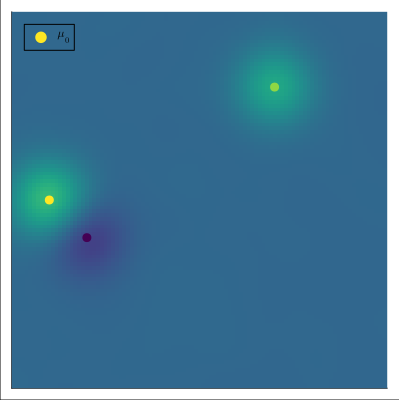

In [73]:
y0 = ops.Φ(μ0...)

# Add noise to the observation y = y0 + w
sigma = noise_level * norm(y0)
w = randn(length(y0))
w = w / norm(w) * sigma
y = y0 + w

plt_obs = deepcopy(plt)

heatmap!(plt_obs, hm_grid, hm_grid, ops.adjΦ(y, grid=plt_grids), color=:viridis)
plot_spikes!(plt_obs, μ0, label=L"μ_0", markersize=5, colorscheme=:viridis)

## Pre-certificate

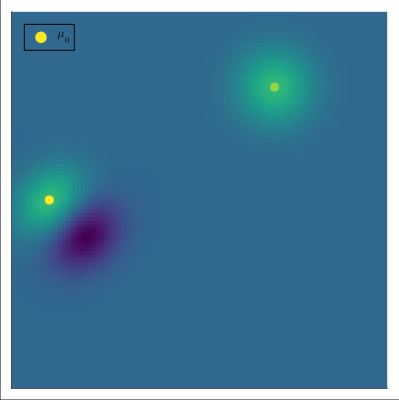

In [74]:
ηV = build_ηV(μ0, ops)

plt_cert = deepcopy(plt)

heatmap!(plt_cert, hm_grid, hm_grid, ηV(plt_grids), color=:viridis)
plot_spikes!(plt_cert, μ0, label=L"μ_0", markersize=5, colorscheme=:viridis)

### SFW

In [75]:
# Define λ the regularisation parameter
λ = 0.06

prob = BLASSO(y, ops, domain, n_coarse_grid, λ=λ)
solve!(prob, :SFW, options=Dict(:maxits => 6))

BLASSO([0.022804691346354437, 0.02823368158514089, -0.03152719126135406, -0.036209370306790126, 0.00762731387911721, -0.0011180656083997148, -0.013498934083915842, -0.022370223175007583, -0.017212690655090908, 0.011625227062515226  …  -0.00571944119112732, -0.0003313376691821527, -0.006078501622717245, 0.053672467980933766, 0.00806277829351185, -0.012453289862012851, -0.01909574116659291, 5.942340089985513e-6, 0.0019203998483912671, 0.022523587782612653], Operators(var"#ϕ#636"{var"#gauss2D#635"{Float64, Int64, Vector{Float64}, Vector{Float64}}, Int64}(var"#gauss2D#635"{Float64, Int64, Vector{Float64}, Vector{Float64}}(199.99999999999997, 441, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45  …  0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]), 441, Core.Box(var"#ϕ#636"{var"#gauss2D#635"{Float64, Int64, Vector{Float64}, Vector{Float64}}, Int64}(#= circular reference @-2 

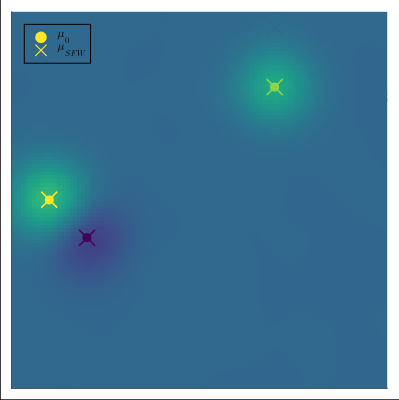

In [76]:
plt_sfw = deepcopy(plt_obs)

plot_spikes!(plt_sfw, prob.μ, label=L"μ_{SFW}", marker=:x, markersize=8, markerstrokewidth=2)